# Mean-Field Optimal Execution - Direct MFC method report

> Tip: The notebook assumes `mf_optimal_execution` package is installed (editable mode is fine):  
> `pip install -e ..` and restart the kernel.

In [1]:
from pathlib import Path

import torch
import numpy as np
import matplotlib.pyplot as plt

from mf_optimal_execution.models import PriceImpactModel
from mf_optimal_execution.solutions import OptimalExecutionSolutionFBSDE_MFC
from mf_optimal_execution.networks import DirectMFCModel
from mf_optimal_execution.utils import setup_plt
from mf_optimal_execution.config import Config

In [2]:
CHECKPOINTS_PATH = Path("../checkpoints")

checkpoint_path = None
if checkpoint_path is None:
    candidates = sorted((p for p in CHECKPOINTS_PATH.glob("direct_mfc_*.pt")), key=lambda p: p.stat().st_mtime, reverse=True)
    checkpoint_path = candidates[0]

print(f"Will load: '{checkpoint_path.name}'")

Will load: 'direct_mfc_1760026562.pt'


## Load checkpoint

In [3]:
setup_plt()

ckpt = torch.load(checkpoint_path)

cfg = Config(**ckpt["config"])


dyn = PriceImpactModel(cfg.sigma, cfg.gamma, cfg.ca, cfg.cx, cfg.cg)
sol = OptimalExecutionSolutionFBSDE_MFC(dyn, cfg)

# Recreate and load model
model = DirectMFCModel(dyn, cfg.maturity)
model.load_state_dict(ckpt["model"], strict=True)
model.eval()

# Training curves
losses = ckpt.get("losses", None)
mean_errors = ckpt.get("mean_errors", None)
std_errors = ckpt.get("std_errors", None)

## Plot results

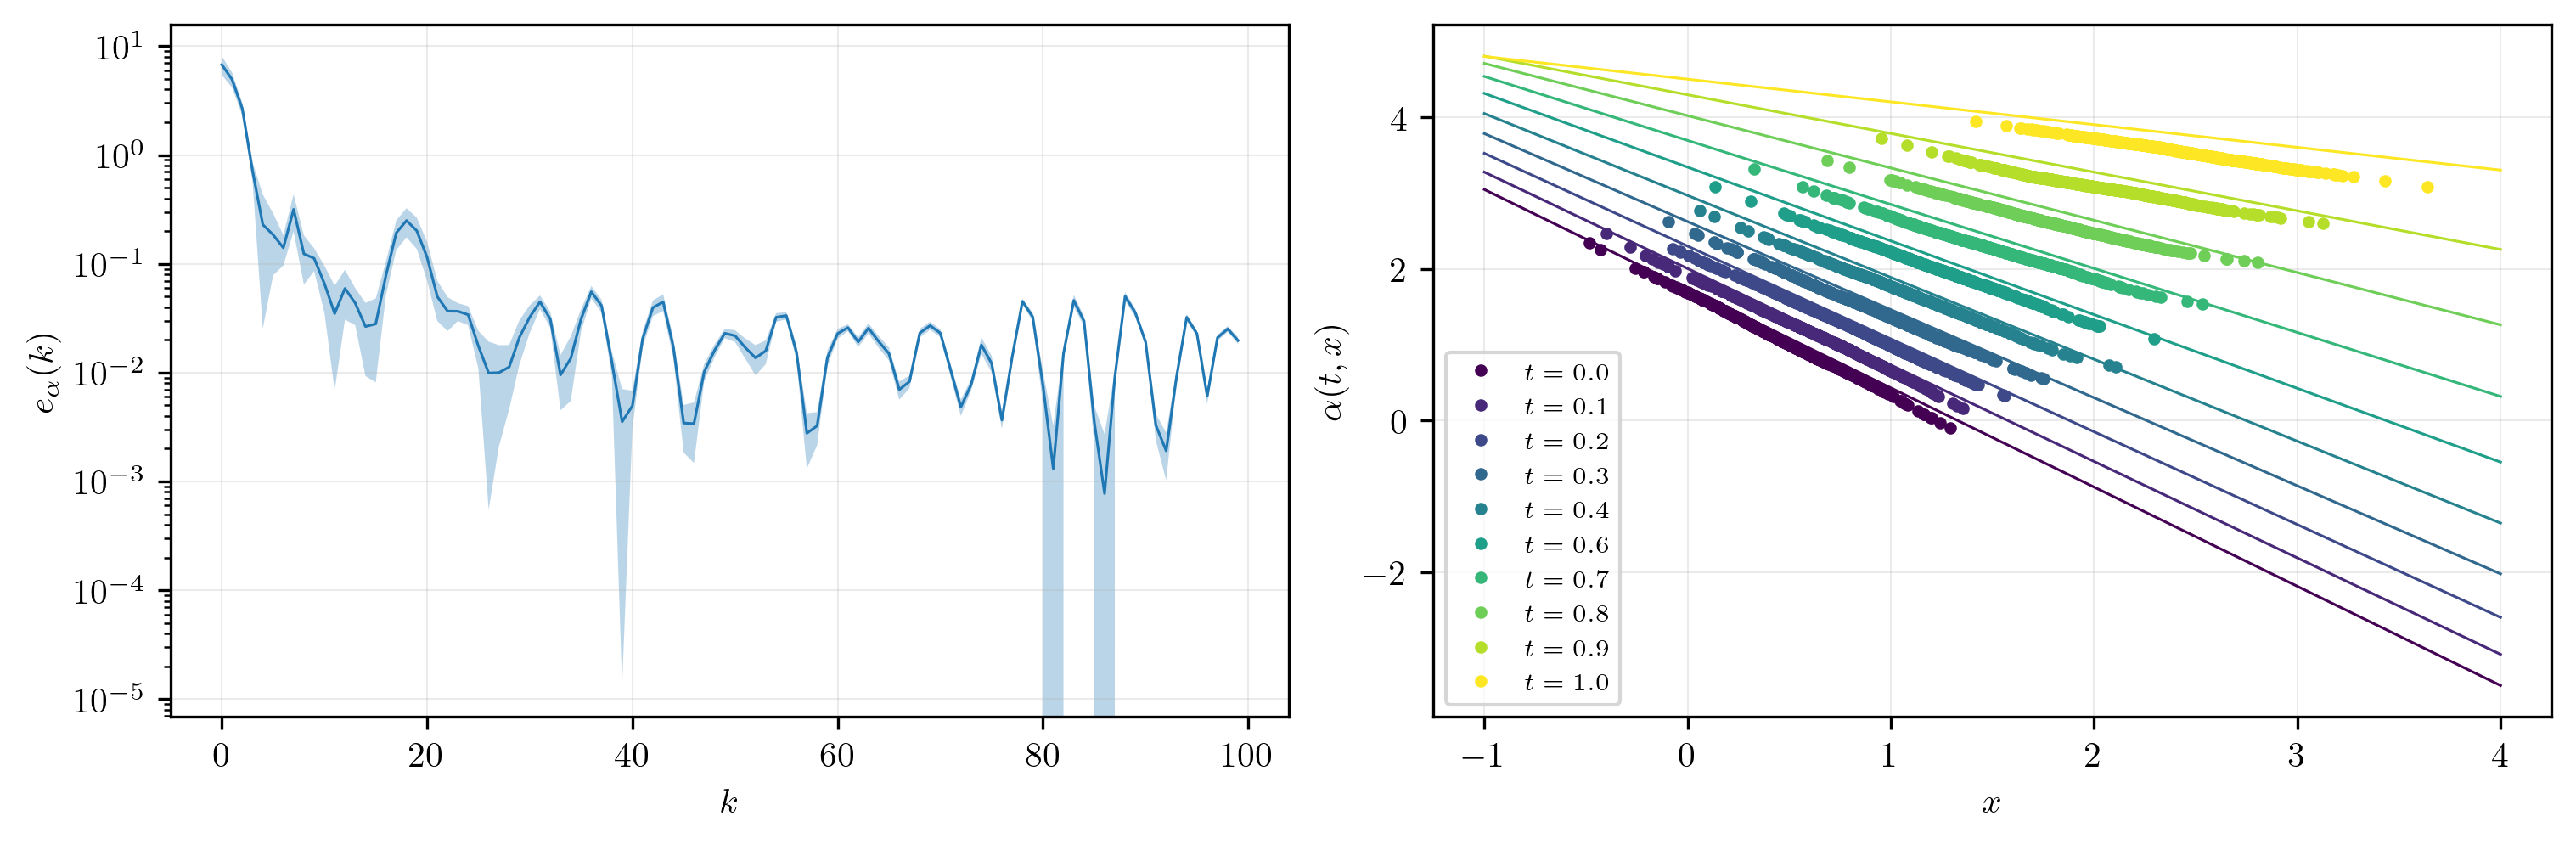

In [4]:
n_sample, time_step = 4_000, 200
dt = cfg.maturity / time_step

# t = torch.linspace(0, cfg.maturity, time_step + 1)
x = cfg.x0_std * torch.randn((n_sample, 1)) + cfg.x0_mean
dw = dt**0.5 * torch.randn((n_sample, time_step, 1))

xx, aa = model.build_trajectories(x, dw)
x_values = np.linspace(-1, 4, 100)
x_epoch = np.arange(len(losses))

cmap = plt.get_cmap("viridis")
fig, axs = plt.subplots(1, 2, figsize=(10, 3.2), dpi=300, constrained_layout=True)

axs[0].plot(x_epoch, mean_errors, lw=0.75)
axs[0].fill_between(x_epoch, mean_errors - std_errors, mean_errors + std_errors, alpha=0.3)
axs[0].set_ylabel(r"$e_\alpha(k)$")
axs[0].set_xlabel("$k$")
axs[0].set_yscale("log")
axs[0].grid(lw=0.5, alpha=0.25)

for i in np.linspace(0, 1, 10):
    idx = int(i * time_step)
    axs[1].plot(x_values, sol.alpha(idx * dt, x_values), lw=0.75, c=cmap(i))
    axs[1].plot(xx[:400, idx], aa[:400, idx], ".", ms=5, c=cmap(i), label=f"$t={idx*dt:.1f}$")
axs[1].set_xlabel(f"$x$")
axs[1].set_ylabel(r"$\alpha(t,x)$")
axs[1].grid(lw=0.5, alpha=0.25)
axs[1].legend(fontsize=7)

plt.show()